In [1]:
import numpy as np
import cv2
import wget
from zipfile import ZipFile
import os

#######################################################

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten
#from tensorflow.keras import utils as np_utils # transform les label en categories
import matplotlib.pyplot as plt
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.activations import *
from tensorflow.keras.datasets import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *


In [2]:
DATASET_URL = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18648/1026645/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1590765878&Signature=lWaCgzE5%2FZYXHtfm16YFKzQ9TqxWAOzh7insAs6qS5b4naboqxje%2FmUWdjALcswZLsB4VzzKNg8ZSUqmx87UX7jRqnlEQCAevlmBDWb4UIvvfErIJnGs%2BNTCtu1MAligXP1CEE%2BVS0rPWuJPe9eNkrtLz5EKd3Bd6Qbk%2Bgp4xO9sFzMVd%2BD11OfypzT9DvPLhYv6zfQU4pNI4DRHCqU1nlCL%2BW5fzB3PUbMDKpVj7axreGcMAJmqYbZHsUXc49SwR7ZMhx3yk6Inkzp6W83b2J2OmCJiA9Az%2Bjd9VEVTaST1r3Hm6m6peAZc1Jn%2BI3%2FNE6DkH%2BVK7zGxs9mlkrq5lg%3D%3D&response-content-disposition=attachment%3B+filename%3Dplant-pathology-2020-fgvc7.zip"
DATASET_TARGET = "./data/"
TRAIN_CSV_PATH = "./data/train.csv"
IMG_PATH = "./data/images/"
IMG_EXT = ".jpg"
TRAIN_PROPORTION = 0.8

In [3]:
def download_dataset():
    print("Plant Health dataset downloading.")

    try:
        os.mkdir(DATASET_TARGET)
        print("Creation of {}.".format(DATASET_TARGET))
    except FileExistsError as e:
        print("Directory {} already exist.".format(DATASET_TARGET))
        if os.path.exists(DATASET_TARGET) and os.path.exists(TRAIN_CSV_PATH) and os.path.exists(IMG_PATH):
            print("Dataset already install.")
            return

    print("Downloading dataset from kaggle.")
    filename = wget.download(DATASET_URL, DATASET_TARGET)

    print("Extract dataset of {}.".format(filename))
    with ZipFile(filename) as zf:
        zf.extractall(DATASET_TARGET)

    os.remove(filename)



In [4]:
# retourne le nom des échantillojn avec leur pathologie
def get_all_dataset(train_path):
    try:

        print("Load plant image names and pathologies.")
        file = open(train_path, "r")
        lines = file.readlines()
        lines = lines[1:]
        img_label = []
        expectations = []

        i = 0
        while i < len(lines):
            lines[i] = lines[i].replace("\n", "")
            row = lines[i].split(",")
            pathology = [row[1], row[2], row[3], row[4]]
            img_label.append(row[0])
            expectations.append(pathology.index("1"))
            i += 1

        return img_label, expectations

    except Exception as e:

        print(e)



In [5]:
# retourne les images à partir de leurs noms
def get_img(img_label, img_path, img_size):
    try:

        print("Load plant images.")
        imgs = []

        for label in img_label:
            img_np = cv2.imread(img_path + label + IMG_EXT)
            img_np = cv2.resize(img_np, img_size)
            imgs.append(img_np)

        return imgs

    except Exception as e:

        print(e)


In [6]:
# forme le dataset
def get_final_dataset(imgs, expectations):
    try:

        print("Creation of the final dataset.")
        x_train = []
        y_train = []
        x_test = []
        y_test = []

        nb_train_data = int(len(imgs) * TRAIN_PROPORTION)

        for i in range(0, len(imgs)):

            if i < nb_train_data:
                x_train.append(imgs[i])
                y_train.append(expectations[i])

            else:
                x_test.append(imgs[i])
                y_test.append(expectations[i])

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    except Exception as e:

        print(e)


In [7]:
# fonction a appelé pour charger le dataset
def load_dataset(img_size):
    download_dataset()
    img_lab, expectations = get_all_dataset(TRAIN_CSV_PATH)
    imgs = get_img(img_lab, IMG_PATH, img_size)
    return get_final_dataset(imgs, expectations)

In [8]:
x_train, y_train,x_test, y_test=load_dataset((64,64))

Plant Health dataset downloading.
Directory ./data/ already exist.
Dataset already install.
Load plant image names and pathologies.
Load plant images.
Creation of the final dataset.


In [9]:
print(x_train.shape)
print(y_train.shape)

(1456, 128, 128, 3)
(1456,)


In [9]:
mean = np.mean(x_train, axis= (0,1,2,3))
std = np.std(x_train ,axis= (0,1,2,3))
x_train = (x_train - mean)/ (std+ 1e-7)
x_test = (x_test - mean)/ (std+ 1e-7)

In [10]:
input_shape= (64,64,3)

In [11]:
## Variation de la valeur de dropout entre les differente couche


def creatModel():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 128, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return classifier

classifier= creatModel()

In [12]:
history = classifier.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 9s 6ms/sample - loss: 1.7899 - sparse_categorical_accuracy: 0.3269 - val_loss: 1.3028 - val_sparse_categorical_accuracy: 0.3123
Epoch 2/200
1456/1456 [==============================] - 1s 441us/sample - loss: 1.2413 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.3106 - val_sparse_categorical_accuracy: 0.4493
Epoch 3/200
1456/1456 [==============================] - 1s 434us/sample - loss: 1.1973 - sparse_categorical_accuracy: 0.4299 - val_loss: 1.2919 - val_sparse_categorical_accuracy: 0.4630
Epoch 4/200
1456/1456 [==============================] - 1s 433us/sample - loss: 1.1661 - sparse_categorical_accuracy: 0.4416 - val_loss: 1.2654 - val_sparse_categorical_accuracy: 0.3945
Epoch 5/200
1456/1456 [==============================] - 1s 439us/sample - loss: 1.1684 - sparse_categorical_accuracy: 0.4471 - val_loss: 1.2518 - val_sparse_categorical_accuracy: 0.4082
Epoch 6/200
1456/145

1456/1456 [==============================] - 1s 443us/sample - loss: 0.0436 - sparse_categorical_accuracy: 0.9863 - val_loss: 1.3539 - val_sparse_categorical_accuracy: 0.4740
Epoch 45/200
1456/1456 [==============================] - 1s 455us/sample - loss: 0.0669 - sparse_categorical_accuracy: 0.9794 - val_loss: 1.3309 - val_sparse_categorical_accuracy: 0.4767
Epoch 46/200
1456/1456 [==============================] - 1s 469us/sample - loss: 0.0545 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.4182 - val_sparse_categorical_accuracy: 0.4658
Epoch 47/200
1456/1456 [==============================] - 1s 462us/sample - loss: 0.0461 - sparse_categorical_accuracy: 0.9863 - val_loss: 1.3689 - val_sparse_categorical_accuracy: 0.4685
Epoch 48/200
1456/1456 [==============================] - 1s 440us/sample - loss: 0.0377 - sparse_categorical_accuracy: 0.9897 - val_loss: 1.3807 - val_sparse_categorical_accuracy: 0.4521
Epoch 49/200
1456/1456 [==============================] - 1s 450us/sample

Epoch 88/200
1456/1456 [==============================] - 1s 445us/sample - loss: 0.0126 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.4888 - val_sparse_categorical_accuracy: 0.4685
Epoch 89/200
1456/1456 [==============================] - 1s 467us/sample - loss: 0.0134 - sparse_categorical_accuracy: 0.9966 - val_loss: 1.4823 - val_sparse_categorical_accuracy: 0.4795
Epoch 90/200
1456/1456 [==============================] - 1s 448us/sample - loss: 0.0107 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.4959 - val_sparse_categorical_accuracy: 0.4877
Epoch 91/200
1456/1456 [==============================] - 1s 473us/sample - loss: 0.0137 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.4893 - val_sparse_categorical_accuracy: 0.4849
Epoch 92/200
1456/1456 [==============================] - 1s 451us/sample - loss: 0.0067 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.5034 - val_sparse_categorical_accuracy: 0.4603
Epoch 93/200
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 466us/sample - loss: 0.0186 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.5084 - val_sparse_categorical_accuracy: 0.4575
Epoch 132/200
1456/1456 [==============================] - 1s 462us/sample - loss: 0.0180 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.6694 - val_sparse_categorical_accuracy: 0.4685
Epoch 133/200
1456/1456 [==============================] - 1s 480us/sample - loss: 0.0225 - sparse_categorical_accuracy: 0.9945 - val_loss: 1.5916 - val_sparse_categorical_accuracy: 0.4740
Epoch 134/200
1456/1456 [==============================] - 1s 442us/sample - loss: 0.0130 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.5928 - val_sparse_categorical_accuracy: 0.4740
Epoch 135/200
1456/1456 [==============================] - 1s 451us/sample - loss: 0.0144 - sparse_categorical_accuracy: 0.9945 - val_loss: 1.6496 - val_sparse_categorical_accuracy: 0.4466
Epoch 136/200
1456/1456 [==============================] - 1s 441us/s

1456/1456 [==============================] - 1s 486us/sample - loss: 0.0134 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.6527 - val_sparse_categorical_accuracy: 0.4740
Epoch 175/200
1456/1456 [==============================] - 1s 464us/sample - loss: 0.0177 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.5442 - val_sparse_categorical_accuracy: 0.4932
Epoch 176/200
1456/1456 [==============================] - 1s 448us/sample - loss: 0.0229 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.5627 - val_sparse_categorical_accuracy: 0.5014
Epoch 177/200
1456/1456 [==============================] - 1s 461us/sample - loss: 0.0108 - sparse_categorical_accuracy: 0.9966 - val_loss: 1.6272 - val_sparse_categorical_accuracy: 0.4849
Epoch 178/200
1456/1456 [==============================] - 1s 449us/sample - loss: 0.0073 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.6234 - val_sparse_categorical_accuracy: 0.4740
Epoch 179/200
1456/1456 [==============================] - 1s 444us/s

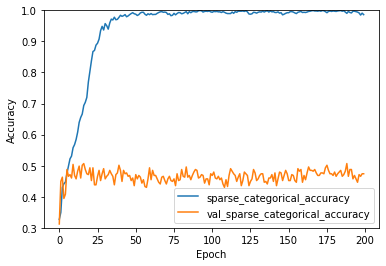

In [13]:
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [14]:
## augmenter la taille des images dans le conv a 128

def creatModel_1():
    classifier= Sequential()
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.1))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.1))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    #classifier.add(Dense(units= 128, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

classifier_1= creatModel()

In [15]:
history_1 = classifier_1.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_test, y_test))



Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 946us/sample - loss: 1.5362 - sparse_categorical_accuracy: 0.3249 - val_loss: 1.3197 - val_sparse_categorical_accuracy: 0.3726
Epoch 2/200
1456/1456 [==============================] - 1s 454us/sample - loss: 1.2272 - sparse_categorical_accuracy: 0.3839 - val_loss: 1.2726 - val_sparse_categorical_accuracy: 0.3945
Epoch 3/200
1456/1456 [==============================] - 1s 471us/sample - loss: 1.1885 - sparse_categorical_accuracy: 0.4286 - val_loss: 1.2456 - val_sparse_categorical_accuracy: 0.4521
Epoch 4/200
1456/1456 [==============================] - 1s 468us/sample - loss: 1.1341 - sparse_categorical_accuracy: 0.4835 - val_loss: 1.2297 - val_sparse_categorical_accuracy: 0.4932
Epoch 5/200
1456/1456 [==============================] - 1s 464us/sample - loss: 1.0922 - sparse_categorical_accuracy: 0.5048 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.4274
Epoch 6/200
1456/1

1456/1456 [==============================] - 1s 467us/sample - loss: 0.0822 - sparse_categorical_accuracy: 0.9732 - val_loss: 1.6505 - val_sparse_categorical_accuracy: 0.4438
Epoch 45/200
1456/1456 [==============================] - 1s 476us/sample - loss: 0.0649 - sparse_categorical_accuracy: 0.9794 - val_loss: 1.6112 - val_sparse_categorical_accuracy: 0.4247
Epoch 46/200
1456/1456 [==============================] - 1s 479us/sample - loss: 0.0374 - sparse_categorical_accuracy: 0.9876 - val_loss: 1.6149 - val_sparse_categorical_accuracy: 0.4356
Epoch 47/200
1456/1456 [==============================] - 1s 507us/sample - loss: 0.0430 - sparse_categorical_accuracy: 0.9835 - val_loss: 1.5703 - val_sparse_categorical_accuracy: 0.4521
Epoch 48/200
1456/1456 [==============================] - 1s 495us/sample - loss: 0.0258 - sparse_categorical_accuracy: 0.9897 - val_loss: 1.7408 - val_sparse_categorical_accuracy: 0.4247
Epoch 49/200
1456/1456 [==============================] - 1s 520us/sample

1456/1456 [==============================] - 1s 502us/sample - loss: 0.0382 - sparse_categorical_accuracy: 0.9883 - val_loss: 1.8421 - val_sparse_categorical_accuracy: 0.4164
Epoch 88/200
1456/1456 [==============================] - 1s 459us/sample - loss: 0.0388 - sparse_categorical_accuracy: 0.9863 - val_loss: 1.8021 - val_sparse_categorical_accuracy: 0.4521
Epoch 89/200
1456/1456 [==============================] - 1s 492us/sample - loss: 0.0349 - sparse_categorical_accuracy: 0.9890 - val_loss: 1.8978 - val_sparse_categorical_accuracy: 0.4575
Epoch 90/200
1456/1456 [==============================] - 1s 488us/sample - loss: 0.0253 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.8725 - val_sparse_categorical_accuracy: 0.4438
Epoch 91/200
1456/1456 [==============================] - 1s 467us/sample - loss: 0.0151 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.8207 - val_sparse_categorical_accuracy: 0.4548
Epoch 92/200
1456/1456 [==============================] - 1s 506us/sample

1456/1456 [==============================] - 1s 469us/sample - loss: 0.0187 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.9007 - val_sparse_categorical_accuracy: 0.4658
Epoch 131/200
1456/1456 [==============================] - 1s 514us/sample - loss: 0.0154 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.9507 - val_sparse_categorical_accuracy: 0.4603
Epoch 132/200
1456/1456 [==============================] - 1s 479us/sample - loss: 0.0082 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.9843 - val_sparse_categorical_accuracy: 0.4493
Epoch 133/200
1456/1456 [==============================] - 1s 471us/sample - loss: 0.0106 - sparse_categorical_accuracy: 0.9952 - val_loss: 2.0486 - val_sparse_categorical_accuracy: 0.4603
Epoch 134/200
1456/1456 [==============================] - 1s 475us/sample - loss: 0.0036 - sparse_categorical_accuracy: 0.9993 - val_loss: 2.1154 - val_sparse_categorical_accuracy: 0.4493
Epoch 135/200
1456/1456 [==============================] - 1s 483us/s

1456/1456 [==============================] - 1s 476us/sample - loss: 0.0048 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.9643 - val_sparse_categorical_accuracy: 0.4466
Epoch 174/200
1456/1456 [==============================] - 1s 484us/sample - loss: 0.0104 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.9091 - val_sparse_categorical_accuracy: 0.4247
Epoch 175/200
1456/1456 [==============================] - 1s 467us/sample - loss: 0.0072 - sparse_categorical_accuracy: 0.9966 - val_loss: 2.0175 - val_sparse_categorical_accuracy: 0.4192
Epoch 176/200
1456/1456 [==============================] - 1s 479us/sample - loss: 0.0032 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.0897 - val_sparse_categorical_accuracy: 0.4384
Epoch 177/200
1456/1456 [==============================] - 1s 481us/sample - loss: 0.0025 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.0360 - val_sparse_categorical_accuracy: 0.4274
Epoch 178/200
1456/1456 [==============================] - 1s 474us/s

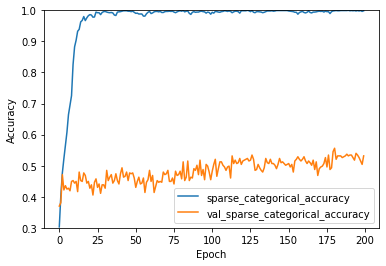

In [17]:
plt.plot(history_1.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history_1.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [16]:
def creatModel_1_():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.2))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 128, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

classifier_1_= creatModel_1_()

In [17]:
history_1 = classifier_1_.fit(x_train, y_train, epochs=180, batch_size=128, validation_data=(x_test, y_test))

Train on 1456 samples, validate on 365 samples
Epoch 1/180
1456/1456 [==============================] - 1s 651us/sample - loss: 2.1326 - accuracy: 0.3029 - val_loss: 1.3781 - val_accuracy: 0.3068
Epoch 2/180
1456/1456 [==============================] - 1s 416us/sample - loss: 1.3760 - accuracy: 0.3324 - val_loss: 1.3723 - val_accuracy: 0.3014
Epoch 3/180
1456/1456 [==============================] - 1s 415us/sample - loss: 1.3591 - accuracy: 0.3324 - val_loss: 1.3338 - val_accuracy: 0.3041
Epoch 4/180
1456/1456 [==============================] - 1s 424us/sample - loss: 1.2836 - accuracy: 0.3400 - val_loss: 1.2619 - val_accuracy: 0.3616
Epoch 5/180
1456/1456 [==============================] - 1s 433us/sample - loss: 1.2364 - accuracy: 0.3771 - val_loss: 1.2659 - val_accuracy: 0.3671
Epoch 6/180
1456/1456 [==============================] - 1s 421us/sample - loss: 1.2233 - accuracy: 0.4025 - val_loss: 1.2442 - val_accuracy: 0.3890
Epoch 7/180
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 414us/sample - loss: 0.0162 - accuracy: 0.9959 - val_loss: 3.8913 - val_accuracy: 0.3753
Epoch 56/180
1456/1456 [==============================] - 1s 422us/sample - loss: 0.0292 - accuracy: 0.9952 - val_loss: 3.7777 - val_accuracy: 0.3699
Epoch 57/180
1456/1456 [==============================] - 1s 406us/sample - loss: 0.0110 - accuracy: 0.9986 - val_loss: 3.8485 - val_accuracy: 0.3616
Epoch 58/180
1456/1456 [==============================] - 1s 425us/sample - loss: 0.0110 - accuracy: 0.9979 - val_loss: 3.9511 - val_accuracy: 0.3671
Epoch 59/180
1456/1456 [==============================] - 1s 418us/sample - loss: 0.0102 - accuracy: 0.9979 - val_loss: 3.9393 - val_accuracy: 0.3836
Epoch 60/180
1456/1456 [==============================] - 1s 409us/sample - loss: 0.0094 - accuracy: 0.9986 - val_loss: 3.9550 - val_accuracy: 0.3644
Epoch 61/180
1456/1456 [==============================] - 1s 424us/sample - loss: 0.0065 - accuracy: 0.9986 - val

1456/1456 [==============================] - 1s 417us/sample - loss: 0.0032 - accuracy: 0.9986 - val_loss: 4.1406 - val_accuracy: 0.3863
Epoch 110/180
1456/1456 [==============================] - 1s 413us/sample - loss: 0.0024 - accuracy: 0.9993 - val_loss: 4.2974 - val_accuracy: 0.3808
Epoch 111/180
1456/1456 [==============================] - 1s 415us/sample - loss: 0.0018 - accuracy: 0.9993 - val_loss: 4.3742 - val_accuracy: 0.3781
Epoch 112/180
1456/1456 [==============================] - 1s 412us/sample - loss: 0.0039 - accuracy: 0.9993 - val_loss: 4.3634 - val_accuracy: 0.3863
Epoch 113/180
1456/1456 [==============================] - 1s 416us/sample - loss: 0.0021 - accuracy: 0.9986 - val_loss: 4.2769 - val_accuracy: 0.3945
Epoch 114/180
1456/1456 [==============================] - 1s 420us/sample - loss: 0.0024 - accuracy: 0.9993 - val_loss: 4.3123 - val_accuracy: 0.3918
Epoch 115/180
1456/1456 [==============================] - 1s 425us/sample - loss: 0.0024 - accuracy: 0.9993

1456/1456 [==============================] - 1s 423us/sample - loss: 0.0032 - accuracy: 0.9986 - val_loss: 4.6802 - val_accuracy: 0.3753
Epoch 164/180
1456/1456 [==============================] - 1s 445us/sample - loss: 0.0015 - accuracy: 0.9993 - val_loss: 4.7098 - val_accuracy: 0.3836
Epoch 165/180
1456/1456 [==============================] - 1s 411us/sample - loss: 0.0039 - accuracy: 0.9986 - val_loss: 4.7589 - val_accuracy: 0.3945
Epoch 166/180
1456/1456 [==============================] - 1s 416us/sample - loss: 0.0011 - accuracy: 0.9993 - val_loss: 4.6712 - val_accuracy: 0.3836
Epoch 167/180
1456/1456 [==============================] - 1s 418us/sample - loss: 0.0065 - accuracy: 0.9993 - val_loss: 4.6913 - val_accuracy: 0.3890
Epoch 168/180
1456/1456 [==============================] - 1s 419us/sample - loss: 0.0036 - accuracy: 0.9993 - val_loss: 4.7938 - val_accuracy: 0.3890
Epoch 169/180
1456/1456 [==============================] - 1s 410us/sample - loss: 0.0022 - accuracy: 0.9993

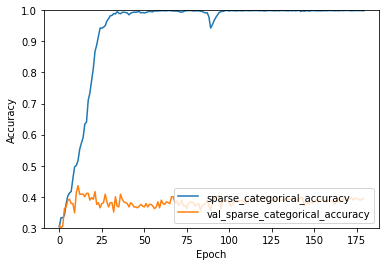

In [23]:
plt.plot(history_1.history['accuracy'], label='sparse_categorical_accuracy')
plt.plot(history_1.history['val_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [24]:
def creatModel_2():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    #classifier.add(Dense(units= 128, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier
classifier_2= creatModel_2()


In [25]:
history_2 = classifier_2.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 707us/sample - loss: 1.3308 - accuracy: 0.3620 - val_loss: 1.2871 - val_accuracy: 0.3753
Epoch 2/200
1456/1456 [==============================] - 1s 436us/sample - loss: 1.2070 - accuracy: 0.4135 - val_loss: 1.2510 - val_accuracy: 0.4356
Epoch 3/200
1456/1456 [==============================] - 1s 446us/sample - loss: 1.1673 - accuracy: 0.4505 - val_loss: 1.2224 - val_accuracy: 0.4219
Epoch 4/200
1456/1456 [==============================] - 1s 455us/sample - loss: 1.1367 - accuracy: 0.4897 - val_loss: 1.2193 - val_accuracy: 0.4849
Epoch 5/200
1456/1456 [==============================] - 1s 433us/sample - loss: 1.0834 - accuracy: 0.5282 - val_loss: 1.2178 - val_accuracy: 0.4301
Epoch 6/200
1456/1456 [==============================] - 1s 438us/sample - loss: 1.0567 - accuracy: 0.5446 - val_loss: 1.1806 - val_accuracy: 0.4740
Epoch 7/200
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 449us/sample - loss: 0.0456 - accuracy: 0.9863 - val_loss: 1.7146 - val_accuracy: 0.4712
Epoch 56/200
1456/1456 [==============================] - 1s 454us/sample - loss: 0.0330 - accuracy: 0.9938 - val_loss: 1.7493 - val_accuracy: 0.4986
Epoch 57/200
1456/1456 [==============================] - 1s 441us/sample - loss: 0.0456 - accuracy: 0.9863 - val_loss: 1.8327 - val_accuracy: 0.4849
Epoch 58/200
1456/1456 [==============================] - 1s 433us/sample - loss: 0.0538 - accuracy: 0.9835 - val_loss: 1.7345 - val_accuracy: 0.4767
Epoch 59/200
1456/1456 [==============================] - 1s 428us/sample - loss: 0.0496 - accuracy: 0.9835 - val_loss: 1.8235 - val_accuracy: 0.4493
Epoch 60/200
1456/1456 [==============================] - 1s 440us/sample - loss: 0.0620 - accuracy: 0.9801 - val_loss: 1.7259 - val_accuracy: 0.4438
Epoch 61/200
1456/1456 [==============================] - 1s 431us/sample - loss: 0.0395 - accuracy: 0.9856 - val

1456/1456 [==============================] - 1s 422us/sample - loss: 0.0149 - accuracy: 0.9966 - val_loss: 1.9176 - val_accuracy: 0.5178
Epoch 110/200
1456/1456 [==============================] - 1s 432us/sample - loss: 0.0072 - accuracy: 0.9986 - val_loss: 1.9438 - val_accuracy: 0.4986
Epoch 111/200
1456/1456 [==============================] - 1s 438us/sample - loss: 0.0104 - accuracy: 0.9973 - val_loss: 1.9223 - val_accuracy: 0.5068
Epoch 112/200
1456/1456 [==============================] - 1s 442us/sample - loss: 0.0152 - accuracy: 0.9952 - val_loss: 1.9731 - val_accuracy: 0.4904
Epoch 113/200
1456/1456 [==============================] - 1s 428us/sample - loss: 0.0185 - accuracy: 0.9959 - val_loss: 1.8687 - val_accuracy: 0.5178
Epoch 114/200
1456/1456 [==============================] - 1s 431us/sample - loss: 0.0070 - accuracy: 0.9993 - val_loss: 1.8460 - val_accuracy: 0.5123
Epoch 115/200
1456/1456 [==============================] - 1s 437us/sample - loss: 0.0152 - accuracy: 0.9979

1456/1456 [==============================] - 1s 453us/sample - loss: 0.0483 - accuracy: 0.9849 - val_loss: 2.0747 - val_accuracy: 0.4795
Epoch 164/200
1456/1456 [==============================] - 1s 456us/sample - loss: 0.0347 - accuracy: 0.9911 - val_loss: 1.9562 - val_accuracy: 0.5041
Epoch 165/200
1456/1456 [==============================] - 1s 456us/sample - loss: 0.0389 - accuracy: 0.9883 - val_loss: 2.0534 - val_accuracy: 0.4575
Epoch 166/200
1456/1456 [==============================] - 1s 460us/sample - loss: 0.0432 - accuracy: 0.9870 - val_loss: 2.0089 - val_accuracy: 0.4685
Epoch 167/200
1456/1456 [==============================] - 1s 455us/sample - loss: 0.0181 - accuracy: 0.9931 - val_loss: 2.0080 - val_accuracy: 0.5151
Epoch 168/200
1456/1456 [==============================] - 1s 430us/sample - loss: 0.0201 - accuracy: 0.9945 - val_loss: 2.0077 - val_accuracy: 0.4959
Epoch 169/200
1456/1456 [==============================] - 1s 429us/sample - loss: 0.0157 - accuracy: 0.9966

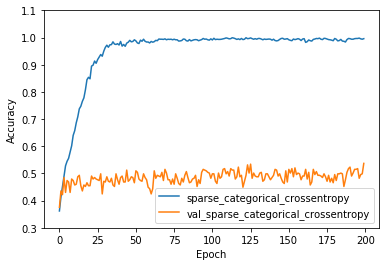

In [30]:
plt.plot(history_2.history['accuracy'], label='sparse_categorical_crossentropy')
plt.plot(history_2.history['val_accuracy'], label='val_sparse_categorical_crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.1])
plt.legend(loc='lower right')

In [31]:
def creatModel_2_():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.3))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 128, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier
classifier_2_= creatModel_2_()


In [33]:
history_2_= classifier_2_.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 435us/sample - loss: 0.9641 - accuracy: 0.5996 - val_loss: 1.1584 - val_accuracy: 0.4712
Epoch 2/200
1456/1456 [==============================] - 1s 431us/sample - loss: 0.9268 - accuracy: 0.6044 - val_loss: 1.1736 - val_accuracy: 0.4986
Epoch 3/200
1456/1456 [==============================] - 1s 435us/sample - loss: 0.8681 - accuracy: 0.6408 - val_loss: 1.1915 - val_accuracy: 0.4904
Epoch 4/200
1456/1456 [==============================] - 1s 447us/sample - loss: 0.8051 - accuracy: 0.6724 - val_loss: 1.1685 - val_accuracy: 0.4959
Epoch 5/200
1456/1456 [==============================] - 1s 440us/sample - loss: 0.7242 - accuracy: 0.7033 - val_loss: 1.2245 - val_accuracy: 0.4493
Epoch 6/200
1456/1456 [==============================] - 1s 451us/sample - loss: 0.6671 - accuracy: 0.7301 - val_loss: 1.2094 - val_accuracy: 0.4685
Epoch 7/200
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 443us/sample - loss: 0.0099 - accuracy: 0.9966 - val_loss: 2.2058 - val_accuracy: 0.4548
Epoch 56/200
1456/1456 [==============================] - 1s 438us/sample - loss: 0.0056 - accuracy: 0.9993 - val_loss: 2.2583 - val_accuracy: 0.4603
Epoch 57/200
1456/1456 [==============================] - 1s 448us/sample - loss: 0.0072 - accuracy: 0.9979 - val_loss: 2.4570 - val_accuracy: 0.4466
Epoch 58/200
1456/1456 [==============================] - 1s 449us/sample - loss: 0.0196 - accuracy: 0.9952 - val_loss: 2.2797 - val_accuracy: 0.4329
Epoch 59/200
1456/1456 [==============================] - 1s 441us/sample - loss: 0.0129 - accuracy: 0.9966 - val_loss: 2.2124 - val_accuracy: 0.4712
Epoch 60/200
1456/1456 [==============================] - 1s 433us/sample - loss: 0.0096 - accuracy: 0.9966 - val_loss: 2.2368 - val_accuracy: 0.4384
Epoch 61/200
1456/1456 [==============================] - 1s 430us/sample - loss: 0.0162 - accuracy: 0.9952 - val

1456/1456 [==============================] - 1s 444us/sample - loss: 0.0049 - accuracy: 0.9979 - val_loss: 2.3762 - val_accuracy: 0.4849
Epoch 110/200
1456/1456 [==============================] - 1s 453us/sample - loss: 0.0021 - accuracy: 0.9986 - val_loss: 2.4582 - val_accuracy: 0.4795
Epoch 111/200
1456/1456 [==============================] - 1s 447us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.4822 - val_accuracy: 0.4712
Epoch 112/200
1456/1456 [==============================] - 1s 434us/sample - loss: 0.0049 - accuracy: 0.9973 - val_loss: 2.4696 - val_accuracy: 0.4521
Epoch 113/200
1456/1456 [==============================] - 1s 451us/sample - loss: 0.0146 - accuracy: 0.9959 - val_loss: 2.3911 - val_accuracy: 0.4712
Epoch 114/200
1456/1456 [==============================] - 1s 450us/sample - loss: 0.0049 - accuracy: 0.9979 - val_loss: 2.2468 - val_accuracy: 0.4740
Epoch 115/200
1456/1456 [==============================] - 1s 434us/sample - loss: 0.0074 - accuracy: 0.9973

1456/1456 [==============================] - 1s 450us/sample - loss: 0.0016 - accuracy: 0.9993 - val_loss: 2.5258 - val_accuracy: 0.4630
Epoch 164/200
1456/1456 [==============================] - 1s 449us/sample - loss: 0.0022 - accuracy: 0.9986 - val_loss: 2.5417 - val_accuracy: 0.4630
Epoch 165/200
1456/1456 [==============================] - 1s 434us/sample - loss: 0.0020 - accuracy: 0.9993 - val_loss: 2.5390 - val_accuracy: 0.4658
Epoch 166/200
1456/1456 [==============================] - 1s 443us/sample - loss: 9.3517e-04 - accuracy: 0.9993 - val_loss: 2.5409 - val_accuracy: 0.4658
Epoch 167/200
1456/1456 [==============================] - 1s 452us/sample - loss: 9.3591e-04 - accuracy: 0.9993 - val_loss: 2.5444 - val_accuracy: 0.4603
Epoch 168/200
1456/1456 [==============================] - 1s 438us/sample - loss: 0.0023 - accuracy: 0.9986 - val_loss: 2.5406 - val_accuracy: 0.4630
Epoch 169/200
1456/1456 [==============================] - 1s 449us/sample - loss: 0.0020 - accuracy

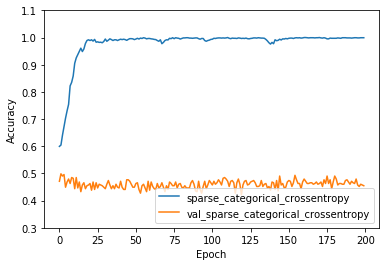

In [35]:
plt.plot(history_2_.history['accuracy'], label='sparse_categorical_crossentropy')
plt.plot(history_2_.history['val_accuracy'], label='val_sparse_categorical_crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.1])
plt.legend(loc='lower right')

In [36]:
def creatModel_3():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 512, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return classifier
classifier_3= creatModel_3()

In [37]:
history_3 = classifier_3.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 724us/sample - loss: 3.0628 - sparse_categorical_accuracy: 0.3132 - val_loss: 1.3000 - val_sparse_categorical_accuracy: 0.3425
Epoch 2/200
1456/1456 [==============================] - 1s 440us/sample - loss: 1.2362 - sparse_categorical_accuracy: 0.3661 - val_loss: 1.2790 - val_sparse_categorical_accuracy: 0.3973
Epoch 3/200
1456/1456 [==============================] - 1s 442us/sample - loss: 1.2031 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.3945
Epoch 4/200
1456/1456 [==============================] - 1s 450us/sample - loss: 1.1827 - sparse_categorical_accuracy: 0.4286 - val_loss: 1.2386 - val_sparse_categorical_accuracy: 0.4384
Epoch 5/200
1456/1456 [==============================] - 1s 454us/sample - loss: 1.1565 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.2480 - val_sparse_categorical_accuracy: 0.4767
Epoch 6/200
1456/1

1456/1456 [==============================] - 1s 442us/sample - loss: 0.0281 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.4085 - val_sparse_categorical_accuracy: 0.4767
Epoch 45/200
1456/1456 [==============================] - 1s 457us/sample - loss: 0.0147 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.4340 - val_sparse_categorical_accuracy: 0.4603
Epoch 46/200
1456/1456 [==============================] - 1s 452us/sample - loss: 0.0196 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.4224 - val_sparse_categorical_accuracy: 0.4795
Epoch 47/200
1456/1456 [==============================] - 1s 444us/sample - loss: 0.0105 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.4057 - val_sparse_categorical_accuracy: 0.4795
Epoch 48/200
1456/1456 [==============================] - 1s 442us/sample - loss: 0.0143 - sparse_categorical_accuracy: 0.9945 - val_loss: 1.4458 - val_sparse_categorical_accuracy: 0.4521
Epoch 49/200
1456/1456 [==============================] - 1s 440us/sample

Epoch 88/200
1456/1456 [==============================] - 1s 440us/sample - loss: 0.0107 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.6268 - val_sparse_categorical_accuracy: 0.4521
Epoch 89/200
1456/1456 [==============================] - 1s 450us/sample - loss: 0.0167 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.4631 - val_sparse_categorical_accuracy: 0.4521
Epoch 90/200
1456/1456 [==============================] - 1s 452us/sample - loss: 0.0184 - sparse_categorical_accuracy: 0.9945 - val_loss: 1.4962 - val_sparse_categorical_accuracy: 0.4493
Epoch 91/200
1456/1456 [==============================] - 1s 450us/sample - loss: 0.0086 - sparse_categorical_accuracy: 0.9993 - val_loss: 1.5186 - val_sparse_categorical_accuracy: 0.4548
Epoch 92/200
1456/1456 [==============================] - 1s 453us/sample - loss: 0.0091 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.5432 - val_sparse_categorical_accuracy: 0.4712
Epoch 93/200
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 448us/sample - loss: 0.0088 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.5788 - val_sparse_categorical_accuracy: 0.4301
Epoch 132/200
1456/1456 [==============================] - 1s 439us/sample - loss: 0.0083 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.6198 - val_sparse_categorical_accuracy: 0.4411
Epoch 133/200
1456/1456 [==============================] - 1s 443us/sample - loss: 0.0103 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.8158 - val_sparse_categorical_accuracy: 0.4219
Epoch 134/200
1456/1456 [==============================] - 1s 453us/sample - loss: 0.0280 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.6083 - val_sparse_categorical_accuracy: 0.4411
Epoch 135/200
1456/1456 [==============================] - 1s 453us/sample - loss: 0.0457 - sparse_categorical_accuracy: 0.9856 - val_loss: 1.6102 - val_sparse_categorical_accuracy: 0.4493
Epoch 136/200
1456/1456 [==============================] - 1s 458us/s

1456/1456 [==============================] - 1s 443us/sample - loss: 0.0052 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.8629 - val_sparse_categorical_accuracy: 0.4411
Epoch 175/200
1456/1456 [==============================] - 1s 445us/sample - loss: 0.0055 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.8142 - val_sparse_categorical_accuracy: 0.4521
Epoch 176/200
1456/1456 [==============================] - 1s 441us/sample - loss: 0.0035 - sparse_categorical_accuracy: 0.9993 - val_loss: 1.8379 - val_sparse_categorical_accuracy: 0.4521
Epoch 177/200
1456/1456 [==============================] - 1s 448us/sample - loss: 0.0070 - sparse_categorical_accuracy: 0.9979 - val_loss: 1.9158 - val_sparse_categorical_accuracy: 0.4548
Epoch 178/200
1456/1456 [==============================] - 1s 451us/sample - loss: 0.0051 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.9156 - val_sparse_categorical_accuracy: 0.4493
Epoch 179/200
1456/1456 [==============================] - 1s 450us/s

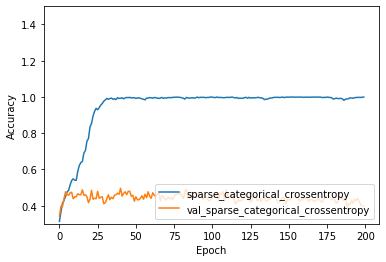

In [47]:
plt.plot(history_3.history['sparse_categorical_accuracy'], label='sparse_categorical_crossentropy')
plt.plot(history_3.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')

In [44]:
def creatModel_4():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 128, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return classifier

classifier_4= creatModel_4()

In [45]:
history_4 = classifier_4.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 719us/sample - loss: 1.7297 - sparse_categorical_accuracy: 0.3077 - val_loss: 1.2958 - val_sparse_categorical_accuracy: 0.3452
Epoch 2/200
1456/1456 [==============================] - 1s 442us/sample - loss: 1.2434 - sparse_categorical_accuracy: 0.3585 - val_loss: 1.3222 - val_sparse_categorical_accuracy: 0.3479
Epoch 3/200
1456/1456 [==============================] - 1s 433us/sample - loss: 1.2177 - sparse_categorical_accuracy: 0.3846 - val_loss: 1.2957 - val_sparse_categorical_accuracy: 0.3699
Epoch 4/200
1456/1456 [==============================] - 1s 438us/sample - loss: 1.1962 - sparse_categorical_accuracy: 0.4073 - val_loss: 1.2822 - val_sparse_categorical_accuracy: 0.4082
Epoch 5/200
1456/1456 [==============================] - 1s 434us/sample - loss: 1.1679 - sparse_categorical_accuracy: 0.4499 - val_loss: 1.2632 - val_sparse_categorical_accuracy: 0.4192
Epoch 6/200
1456/1

1456/1456 [==============================] - 1s 434us/sample - loss: 0.0321 - sparse_categorical_accuracy: 0.9897 - val_loss: 1.4974 - val_sparse_categorical_accuracy: 0.4384
Epoch 45/200
1456/1456 [==============================] - 1s 443us/sample - loss: 0.0350 - sparse_categorical_accuracy: 0.9876 - val_loss: 1.5030 - val_sparse_categorical_accuracy: 0.4411
Epoch 46/200
1456/1456 [==============================] - 1s 443us/sample - loss: 0.0329 - sparse_categorical_accuracy: 0.9890 - val_loss: 1.5643 - val_sparse_categorical_accuracy: 0.4329
Epoch 47/200
1456/1456 [==============================] - 1s 449us/sample - loss: 0.0330 - sparse_categorical_accuracy: 0.9890 - val_loss: 1.4824 - val_sparse_categorical_accuracy: 0.4630
Epoch 48/200
1456/1456 [==============================] - 1s 436us/sample - loss: 0.0229 - sparse_categorical_accuracy: 0.9931 - val_loss: 1.5093 - val_sparse_categorical_accuracy: 0.4548
Epoch 49/200
1456/1456 [==============================] - 1s 453us/sample

Epoch 88/200
1456/1456 [==============================] - 1s 439us/sample - loss: 0.0142 - sparse_categorical_accuracy: 0.9966 - val_loss: 1.7053 - val_sparse_categorical_accuracy: 0.4548
Epoch 89/200
1456/1456 [==============================] - 1s 440us/sample - loss: 0.0154 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.6244 - val_sparse_categorical_accuracy: 0.4740
Epoch 90/200
1456/1456 [==============================] - 1s 451us/sample - loss: 0.0126 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.6636 - val_sparse_categorical_accuracy: 0.4658
Epoch 91/200
1456/1456 [==============================] - 1s 439us/sample - loss: 0.0209 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.6627 - val_sparse_categorical_accuracy: 0.4685
Epoch 92/200
1456/1456 [==============================] - 1s 441us/sample - loss: 0.0110 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.6484 - val_sparse_categorical_accuracy: 0.4822
Epoch 93/200
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 451us/sample - loss: 0.0035 - sparse_categorical_accuracy: 0.9993 - val_loss: 2.0571 - val_sparse_categorical_accuracy: 0.4274
Epoch 132/200
1456/1456 [==============================] - 1s 442us/sample - loss: 0.0024 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.0772 - val_sparse_categorical_accuracy: 0.4356
Epoch 133/200
1456/1456 [==============================] - 1s 453us/sample - loss: 0.0027 - sparse_categorical_accuracy: 0.9993 - val_loss: 1.9758 - val_sparse_categorical_accuracy: 0.4521
Epoch 134/200
1456/1456 [==============================] - 1s 448us/sample - loss: 0.0027 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.9727 - val_sparse_categorical_accuracy: 0.4521
Epoch 135/200
1456/1456 [==============================] - 1s 434us/sample - loss: 0.0025 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.9810 - val_sparse_categorical_accuracy: 0.4658
Epoch 136/200
1456/1456 [==============================] - 1s 440us/s

1456/1456 [==============================] - 1s 446us/sample - loss: 0.0131 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.8406 - val_sparse_categorical_accuracy: 0.4301
Epoch 175/200
1456/1456 [==============================] - 1s 433us/sample - loss: 0.0101 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.8618 - val_sparse_categorical_accuracy: 0.4411
Epoch 176/200
1456/1456 [==============================] - 1s 429us/sample - loss: 0.0176 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.9976 - val_sparse_categorical_accuracy: 0.4521
Epoch 177/200
1456/1456 [==============================] - 1s 442us/sample - loss: 0.0187 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.9744 - val_sparse_categorical_accuracy: 0.4384
Epoch 178/200
1456/1456 [==============================] - 1s 446us/sample - loss: 0.0132 - sparse_categorical_accuracy: 0.9959 - val_loss: 1.9945 - val_sparse_categorical_accuracy: 0.4548
Epoch 179/200
1456/1456 [==============================] - 1s 433us/s

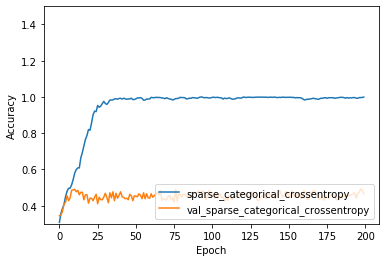

In [50]:
plt.plot(history_4.history['sparse_categorical_accuracy'], label='sparse_categorical_crossentropy')
plt.plot(history_4.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')

In [51]:
def creatModel_5():
    classifier= Sequential()
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    #classifier.add(Dense(units= 256, activation = 'relu'))
    #classifier.add(Dropout(0.5))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

classifier_5= creatModel_5()

In [52]:
history_5 = classifier_5.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 696us/sample - loss: 1.7459 - accuracy: 0.3242 - val_loss: 1.3442 - val_accuracy: 0.3562
Epoch 2/200
1456/1456 [==============================] - 1s 438us/sample - loss: 1.2442 - accuracy: 0.3599 - val_loss: 1.3154 - val_accuracy: 0.4000
Epoch 3/200
1456/1456 [==============================] - 1s 454us/sample - loss: 1.2027 - accuracy: 0.4045 - val_loss: 1.3051 - val_accuracy: 0.4493
Epoch 4/200
1456/1456 [==============================] - 1s 436us/sample - loss: 1.1781 - accuracy: 0.4334 - val_loss: 1.2970 - val_accuracy: 0.4712
Epoch 5/200
1456/1456 [==============================] - 1s 443us/sample - loss: 1.1513 - accuracy: 0.4718 - val_loss: 1.2849 - val_accuracy: 0.4630
Epoch 6/200
1456/1456 [==============================] - 1s 439us/sample - loss: 1.1397 - accuracy: 0.4753 - val_loss: 1.2675 - val_accuracy: 0.4740
Epoch 7/200
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 440us/sample - loss: 0.1505 - accuracy: 0.9505 - val_loss: 0.9951 - val_accuracy: 0.5616
Epoch 56/200
1456/1456 [==============================] - 1s 436us/sample - loss: 0.1356 - accuracy: 0.9540 - val_loss: 0.9791 - val_accuracy: 0.5808
Epoch 57/200
1456/1456 [==============================] - 1s 438us/sample - loss: 0.1194 - accuracy: 0.9554 - val_loss: 1.0054 - val_accuracy: 0.5589
Epoch 58/200
1456/1456 [==============================] - 1s 443us/sample - loss: 0.1167 - accuracy: 0.9574 - val_loss: 0.9633 - val_accuracy: 0.6137
Epoch 59/200
1456/1456 [==============================] - 1s 438us/sample - loss: 0.1055 - accuracy: 0.9663 - val_loss: 0.9567 - val_accuracy: 0.5918
Epoch 60/200
1456/1456 [==============================] - 1s 442us/sample - loss: 0.1011 - accuracy: 0.9691 - val_loss: 0.9725 - val_accuracy: 0.5808
Epoch 61/200
1456/1456 [==============================] - 1s 430us/sample - loss: 0.0764 - accuracy: 0.9718 - val

1456/1456 [==============================] - 1s 445us/sample - loss: 0.0399 - accuracy: 0.9856 - val_loss: 0.9450 - val_accuracy: 0.6219
Epoch 110/200
1456/1456 [==============================] - 1s 435us/sample - loss: 0.0569 - accuracy: 0.9821 - val_loss: 0.9016 - val_accuracy: 0.6630
Epoch 111/200
1456/1456 [==============================] - 1s 438us/sample - loss: 0.0371 - accuracy: 0.9870 - val_loss: 0.9237 - val_accuracy: 0.6329
Epoch 112/200
1456/1456 [==============================] - 1s 433us/sample - loss: 0.0482 - accuracy: 0.9863 - val_loss: 0.9142 - val_accuracy: 0.6411
Epoch 113/200
1456/1456 [==============================] - 1s 440us/sample - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.9229 - val_accuracy: 0.6575
Epoch 114/200
1456/1456 [==============================] - 1s 439us/sample - loss: 0.0379 - accuracy: 0.9883 - val_loss: 0.9316 - val_accuracy: 0.6740
Epoch 115/200
1456/1456 [==============================] - 1s 441us/sample - loss: 0.0515 - accuracy: 0.9849

1456/1456 [==============================] - 1s 437us/sample - loss: 0.0229 - accuracy: 0.9924 - val_loss: 0.8901 - val_accuracy: 0.6767
Epoch 164/200
1456/1456 [==============================] - 1s 435us/sample - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.8819 - val_accuracy: 0.6603
Epoch 165/200
1456/1456 [==============================] - 1s 436us/sample - loss: 0.0324 - accuracy: 0.9890 - val_loss: 0.8901 - val_accuracy: 0.6630
Epoch 166/200
1456/1456 [==============================] - 1s 437us/sample - loss: 0.0252 - accuracy: 0.9911 - val_loss: 0.9180 - val_accuracy: 0.6521
Epoch 167/200
1456/1456 [==============================] - 1s 437us/sample - loss: 0.0252 - accuracy: 0.9904 - val_loss: 0.8940 - val_accuracy: 0.6712
Epoch 168/200
1456/1456 [==============================] - 1s 443us/sample - loss: 0.0325 - accuracy: 0.9918 - val_loss: 0.8883 - val_accuracy: 0.6658
Epoch 169/200
1456/1456 [==============================] - 1s 439us/sample - loss: 0.0246 - accuracy: 0.9924

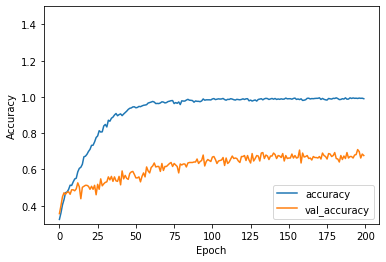

In [53]:
plt.plot(history_5.history['accuracy'], label='accuracy')
plt.plot(history_5.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')

In [54]:
def creatModel_6():
    classifier= Sequential()
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(MaxPooling2D(pool_size=(2,2))) 
    
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 512, activation = 'relu'))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return classifier

classifier_6= creatModel_6()

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 3s 2ms/sample - loss: 5.7840 - sparse_categorical_accuracy: 0.3091 - val_loss: 1.3665 - val_sparse_categorical_accuracy: 0.2822
Epoch 2/200
1456/1456 [==============================] - 1s 853us/sample - loss: 1.2805 - sparse_categorical_accuracy: 0.3468 - val_loss: 1.2821 - val_sparse_categorical_accuracy: 0.3178
Epoch 3/200
1456/1456 [==============================] - 1s 872us/sample - loss: 1.2324 - sparse_categorical_accuracy: 0.3880 - val_loss: 1.2728 - val_sparse_categorical_accuracy: 0.3507
Epoch 4/200
1456/1456 [==============================] - 1s 844us/sample - loss: 1.2225 - sparse_categorical_accuracy: 0.4011 - val_loss: 1.2616 - val_sparse_categorical_accuracy: 0.3397
Epoch 5/200
1456/1456 [==============================] - 1s 846us/sample - loss: 1.1900 - sparse_categorical_accuracy: 0.4203 - val_loss: 1.2475 - val_sparse_categorical_accuracy: 0.3671
Epoch 6/200
1456/145

1456/1456 [==============================] - 1s 843us/sample - loss: 0.0288 - sparse_categorical_accuracy: 0.9931 - val_loss: 2.3795 - val_sparse_categorical_accuracy: 0.3315
Epoch 45/200
1456/1456 [==============================] - 1s 845us/sample - loss: 0.0475 - sparse_categorical_accuracy: 0.9815 - val_loss: 2.0951 - val_sparse_categorical_accuracy: 0.3808
Epoch 46/200
1456/1456 [==============================] - 1s 845us/sample - loss: 0.0353 - sparse_categorical_accuracy: 0.9890 - val_loss: 2.1106 - val_sparse_categorical_accuracy: 0.3699
Epoch 47/200
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0313 - sparse_categorical_accuracy: 0.9911 - val_loss: 2.2377 - val_sparse_categorical_accuracy: 0.3644
Epoch 48/200
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0152 - sparse_categorical_accuracy: 0.9979 - val_loss: 2.1745 - val_sparse_categorical_accuracy: 0.3562
Epoch 49/200
1456/1456 [==============================] - 1s 844us/sample

1456/1456 [==============================] - 1s 843us/sample - loss: 0.0222 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.3239 - val_sparse_categorical_accuracy: 0.3644
Epoch 88/200
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0187 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.4217 - val_sparse_categorical_accuracy: 0.3753
Epoch 89/200
1456/1456 [==============================] - 1s 848us/sample - loss: 0.0179 - sparse_categorical_accuracy: 0.9966 - val_loss: 2.5916 - val_sparse_categorical_accuracy: 0.3562
Epoch 90/200
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0250 - sparse_categorical_accuracy: 0.9918 - val_loss: 2.5230 - val_sparse_categorical_accuracy: 0.3644
Epoch 91/200
1456/1456 [==============================] - 1s 848us/sample - loss: 0.0191 - sparse_categorical_accuracy: 0.9959 - val_loss: 2.6093 - val_sparse_categorical_accuracy: 0.3726
Epoch 92/200
1456/1456 [==============================] - 1s 842us/sample

1456/1456 [==============================] - 1s 846us/sample - loss: 0.0098 - sparse_categorical_accuracy: 0.9979 - val_loss: 2.7029 - val_sparse_categorical_accuracy: 0.3562
Epoch 131/200
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0035 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.7491 - val_sparse_categorical_accuracy: 0.3507
Epoch 132/200
1456/1456 [==============================] - 1s 845us/sample - loss: 0.0044 - sparse_categorical_accuracy: 0.9979 - val_loss: 2.8008 - val_sparse_categorical_accuracy: 0.3507
Epoch 133/200
1456/1456 [==============================] - 1s 846us/sample - loss: 0.0030 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.8758 - val_sparse_categorical_accuracy: 0.3534
Epoch 134/200
1456/1456 [==============================] - 1s 847us/sample - loss: 0.0033 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.9517 - val_sparse_categorical_accuracy: 0.3507
Epoch 135/200
1456/1456 [==============================] - 1s 843us/s

1456/1456 [==============================] - 1s 844us/sample - loss: 0.0241 - sparse_categorical_accuracy: 0.9924 - val_loss: 2.7896 - val_sparse_categorical_accuracy: 0.3644
Epoch 174/200
1456/1456 [==============================] - 1s 852us/sample - loss: 0.0182 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.6717 - val_sparse_categorical_accuracy: 0.3644
Epoch 175/200
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0108 - sparse_categorical_accuracy: 0.9966 - val_loss: 2.8206 - val_sparse_categorical_accuracy: 0.3315
Epoch 176/200
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0257 - sparse_categorical_accuracy: 0.9911 - val_loss: 2.7663 - val_sparse_categorical_accuracy: 0.3781
Epoch 177/200
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0229 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.6892 - val_sparse_categorical_accuracy: 0.3863
Epoch 178/200
1456/1456 [==============================] - 1s 843us/s

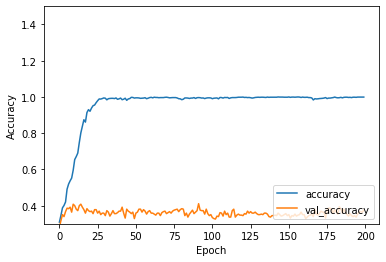

In [55]:
history_6 = classifier_6.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))

plt.plot(history_6.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history_6.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')

In [56]:
def creatModel_7():
    classifier= Sequential()
    classifier.add(Conv2D(128,(3,3),padding= 'same', activation = 'relu',input_shape = (256,256,3)))
    classifier.add(Conv2D(128,(3,3),activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.4))
    
    
    classifier.add(Conv2D(128,(3,3),padding= 'same', activation = 'relu'))
    classifier.add(Conv2D(128,(3,3),activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.4))
    
    
    classifier.add(Conv2D(128,(3,3),padding= 'same', activation = 'relu'))
    classifier.add(Conv2D(128,(3,3),activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.4))
    
    
    classifier.add(Flatten())
    classifier.add(Dense(512, activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units= 4, activation = 'softmax'))
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return classifier

classifier_7= creatModel_1()

In [57]:
history_7 = classifier_7.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 1s 1ms/sample - loss: 1.5254 - accuracy: 0.3455 - val_loss: 1.3391 - val_accuracy: 0.3507
Epoch 2/200
1456/1456 [==============================] - 1s 791us/sample - loss: 1.2679 - accuracy: 0.3592 - val_loss: 1.2589 - val_accuracy: 0.3096
Epoch 3/200
1456/1456 [==============================] - 1s 800us/sample - loss: 1.2179 - accuracy: 0.3997 - val_loss: 1.2001 - val_accuracy: 0.4521
Epoch 4/200
1456/1456 [==============================] - 1s 799us/sample - loss: 1.1523 - accuracy: 0.4650 - val_loss: 1.1706 - val_accuracy: 0.4822
Epoch 5/200
1456/1456 [==============================] - 1s 810us/sample - loss: 1.1113 - accuracy: 0.4918 - val_loss: 1.1578 - val_accuracy: 0.4767
Epoch 6/200
1456/1456 [==============================] - 1s 810us/sample - loss: 1.0769 - accuracy: 0.5165 - val_loss: 1.1704 - val_accuracy: 0.4603
Epoch 7/200
1456/1456 [==============================] - 1s 8

1456/1456 [==============================] - 1s 789us/sample - loss: 0.0142 - accuracy: 0.9979 - val_loss: 3.9478 - val_accuracy: 0.4630
Epoch 56/200
1456/1456 [==============================] - 1s 784us/sample - loss: 0.0110 - accuracy: 0.9986 - val_loss: 4.0342 - val_accuracy: 0.4630
Epoch 57/200
1456/1456 [==============================] - 1s 780us/sample - loss: 0.0143 - accuracy: 0.9979 - val_loss: 4.0734 - val_accuracy: 0.4575
Epoch 58/200
1456/1456 [==============================] - 1s 791us/sample - loss: 0.0168 - accuracy: 0.9979 - val_loss: 4.1094 - val_accuracy: 0.4438
Epoch 59/200
1456/1456 [==============================] - 1s 789us/sample - loss: 0.0134 - accuracy: 0.9993 - val_loss: 4.1643 - val_accuracy: 0.4438
Epoch 60/200
1456/1456 [==============================] - 1s 786us/sample - loss: 0.0133 - accuracy: 0.9979 - val_loss: 4.2303 - val_accuracy: 0.4575
Epoch 61/200
1456/1456 [==============================] - 1s 794us/sample - loss: 0.0121 - accuracy: 0.9986 - val

1456/1456 [==============================] - 1s 784us/sample - loss: 0.0177 - accuracy: 0.9924 - val_loss: 4.8030 - val_accuracy: 0.4356
Epoch 110/200
1456/1456 [==============================] - 1s 792us/sample - loss: 0.0253 - accuracy: 0.9924 - val_loss: 4.6702 - val_accuracy: 0.4548
Epoch 111/200
1456/1456 [==============================] - 1s 791us/sample - loss: 0.0227 - accuracy: 0.9924 - val_loss: 4.6133 - val_accuracy: 0.4521
Epoch 112/200
1456/1456 [==============================] - 1s 788us/sample - loss: 0.0363 - accuracy: 0.9931 - val_loss: 4.6257 - val_accuracy: 0.4685
Epoch 113/200
1456/1456 [==============================] - 1s 796us/sample - loss: 0.0313 - accuracy: 0.9938 - val_loss: 4.5764 - val_accuracy: 0.4438
Epoch 114/200
1456/1456 [==============================] - 1s 788us/sample - loss: 0.0233 - accuracy: 0.9938 - val_loss: 4.7892 - val_accuracy: 0.4575
Epoch 115/200
1456/1456 [==============================] - 1s 791us/sample - loss: 0.0216 - accuracy: 0.9924

1456/1456 [==============================] - 1s 783us/sample - loss: 0.0110 - accuracy: 0.9993 - val_loss: 5.1501 - val_accuracy: 0.4712
Epoch 164/200
1456/1456 [==============================] - 1s 788us/sample - loss: 0.0146 - accuracy: 0.9993 - val_loss: 4.8348 - val_accuracy: 0.4658
Epoch 165/200
1456/1456 [==============================] - 1s 789us/sample - loss: 0.0038 - accuracy: 0.9993 - val_loss: 4.8658 - val_accuracy: 0.4630
Epoch 166/200
1456/1456 [==============================] - 1s 785us/sample - loss: 0.0040 - accuracy: 0.9993 - val_loss: 4.9726 - val_accuracy: 0.4740
Epoch 167/200
1456/1456 [==============================] - 1s 791us/sample - loss: 0.0041 - accuracy: 0.9993 - val_loss: 5.0262 - val_accuracy: 0.4822
Epoch 168/200
1456/1456 [==============================] - 1s 787us/sample - loss: 0.0017 - accuracy: 0.9993 - val_loss: 5.0364 - val_accuracy: 0.4767
Epoch 169/200
1456/1456 [==============================] - 1s 790us/sample - loss: 0.0033 - accuracy: 0.9993

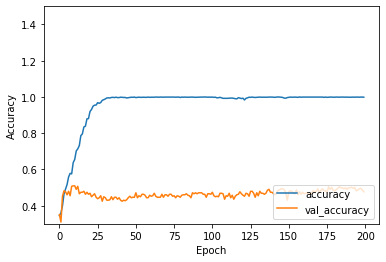

In [60]:
plt.plot(history_7.history['accuracy'], label='accuracy')
plt.plot(history_7.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')

In [61]:
def creatModel_8():
    classifier= Sequential()
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    classifier.add(Dense(units= 256, activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

classifier_8= creatModel_8()

In [62]:
history_8 = classifier_8.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 2s 1ms/sample - loss: 2.4096 - accuracy: 0.3166 - val_loss: 1.3138 - val_accuracy: 0.3452
Epoch 2/200
1456/1456 [==============================] - 1s 881us/sample - loss: 1.2483 - accuracy: 0.3427 - val_loss: 1.3256 - val_accuracy: 0.3753
Epoch 3/200
1456/1456 [==============================] - 1s 857us/sample - loss: 1.2357 - accuracy: 0.3558 - val_loss: 1.2952 - val_accuracy: 0.3644
Epoch 4/200
1456/1456 [==============================] - 1s 865us/sample - loss: 1.2184 - accuracy: 0.3949 - val_loss: 1.2960 - val_accuracy: 0.3699
Epoch 5/200
1456/1456 [==============================] - 1s 854us/sample - loss: 1.1905 - accuracy: 0.4114 - val_loss: 1.3098 - val_accuracy: 0.4411
Epoch 6/200
1456/1456 [==============================] - 1s 840us/sample - loss: 1.1713 - accuracy: 0.4444 - val_loss: 1.2882 - val_accuracy: 0.4685
Epoch 7/200
1456/1456 [==============================] - 1s 8

1456/1456 [==============================] - 1s 861us/sample - loss: 0.1351 - accuracy: 0.9533 - val_loss: 1.2493 - val_accuracy: 0.4356
Epoch 56/200
1456/1456 [==============================] - 1s 868us/sample - loss: 0.1196 - accuracy: 0.9519 - val_loss: 1.2367 - val_accuracy: 0.4274
Epoch 57/200
1456/1456 [==============================] - 1s 857us/sample - loss: 0.1165 - accuracy: 0.9602 - val_loss: 1.2475 - val_accuracy: 0.4521
Epoch 58/200
1456/1456 [==============================] - 1s 858us/sample - loss: 0.0901 - accuracy: 0.9677 - val_loss: 1.2636 - val_accuracy: 0.4521
Epoch 59/200
1456/1456 [==============================] - 1s 859us/sample - loss: 0.1047 - accuracy: 0.9602 - val_loss: 1.2912 - val_accuracy: 0.4466
Epoch 60/200
1456/1456 [==============================] - 1s 860us/sample - loss: 0.1157 - accuracy: 0.9547 - val_loss: 1.2488 - val_accuracy: 0.4630
Epoch 61/200
1456/1456 [==============================] - 1s 866us/sample - loss: 0.1229 - accuracy: 0.9567 - val

1456/1456 [==============================] - 1s 853us/sample - loss: 0.0812 - accuracy: 0.9718 - val_loss: 1.2540 - val_accuracy: 0.4384
Epoch 110/200
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0859 - accuracy: 0.9698 - val_loss: 1.2487 - val_accuracy: 0.4493
Epoch 111/200
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0662 - accuracy: 0.9766 - val_loss: 1.2834 - val_accuracy: 0.4630
Epoch 112/200
1456/1456 [==============================] - 1s 883us/sample - loss: 0.0835 - accuracy: 0.9718 - val_loss: 1.2726 - val_accuracy: 0.4904
Epoch 113/200
1456/1456 [==============================] - 1s 863us/sample - loss: 0.0679 - accuracy: 0.9746 - val_loss: 1.3106 - val_accuracy: 0.4384
Epoch 114/200
1456/1456 [==============================] - 1s 875us/sample - loss: 0.0596 - accuracy: 0.9794 - val_loss: 1.2678 - val_accuracy: 0.4384
Epoch 115/200
1456/1456 [==============================] - 1s 864us/sample - loss: 0.0530 - accuracy: 0.9828

1456/1456 [==============================] - 1s 864us/sample - loss: 0.0644 - accuracy: 0.9815 - val_loss: 1.3048 - val_accuracy: 0.4575
Epoch 164/200
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0512 - accuracy: 0.9787 - val_loss: 1.3360 - val_accuracy: 0.4548
Epoch 165/200
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0643 - accuracy: 0.9801 - val_loss: 1.3501 - val_accuracy: 0.4384
Epoch 166/200
1456/1456 [==============================] - 1s 867us/sample - loss: 0.0411 - accuracy: 0.9849 - val_loss: 1.3552 - val_accuracy: 0.4466
Epoch 167/200
1456/1456 [==============================] - 1s 846us/sample - loss: 0.0572 - accuracy: 0.9801 - val_loss: 1.3272 - val_accuracy: 0.4603
Epoch 168/200
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0470 - accuracy: 0.9849 - val_loss: 1.3126 - val_accuracy: 0.4493
Epoch 169/200
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0511 - accuracy: 0.9821

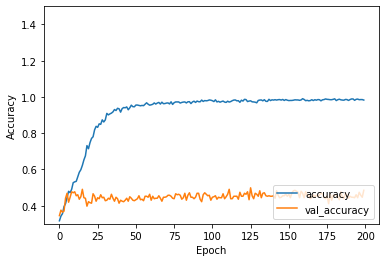

In [63]:
plt.plot(history_8.history['accuracy'], label='accuracy')
plt.plot(history_8.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')